# Set up notebook

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import functions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sc = pyspark.SparkContext(appName="bootstrap")

In [5]:
sqlCtx = pyspark.SQLContext(sc)

# Create Toy Dataset

In [13]:
dist, n = [], 10000000
for i in range(n):
    dist.append(np.random.poisson())

test_fraction = 0.3
test = np.random.poisson(lam=0.8, size=int(n*test_fraction)) * 1.0
ctrl = np.random.poisson(lam=0.75, size=int(n*(1-test_fraction))) * 1.0

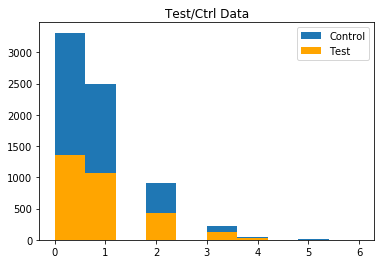

In [7]:
plt.hist(ctrl,label='Control')
plt.hist(test, label='Test', color='orange')
plt.title('Test/Ctrl Data')
plt.legend()
plt.show()

(array([7.355798e+06, 1.840303e+06, 6.141510e+05, 1.531260e+05,
        3.065800e+04, 5.115000e+03, 7.460000e+02, 8.700000e+01,
        1.300000e+01, 3.000000e+00]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

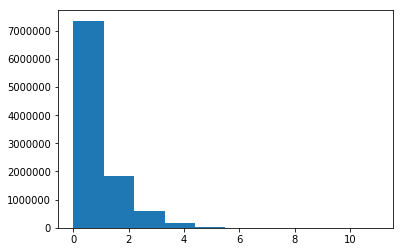

In [17]:
plt.hist(dist)

# Bootstrap with Numpy

In [19]:
num_iterations = 10000
bootstrapped_means_ctrl = []
bootstrapped_means_test = []
for i in range(num_iterations):
    data_bootstrap_ctrl = np.random.choice(ctrl, size=ctrl.shape[0], replace=True)
    data_bootstrap_test = np.random.choice(test, size=test.shape[0], replace=True)
    ctrl_mean = np.mean(data_bootstrap_ctrl)
    test_mean = np.mean(data_bootstrap_test)
    bootstrapped_means_ctrl.append(ctrl_mean)
    bootstrapped_means_test.append(test_mean)
bootstrapped_means_ctrl = np.array(bootstrapped_means_ctrl)
bootstrapped_means_test = np.array(bootstrapped_means_test)
bootstrapped_means_diff = bootstrapped_means_test - bootstrapped_means_ctrl

two tailed stat sig test, null hypothesis of no difference

In [20]:
alpha=0.05
low = np.percentile(bootstrapped_means_diff, 100 * (alpha / 2.))
val = np.percentile(bootstrapped_means_diff, 50)
high = np.percentile(bootstrapped_means_diff, 100 * (1 - alpha / 2.))
x_bar = np.mean(test) - np.mean(ctrl)
print('{}\t({}, {})'.format(val,low,high))
print('p-value: {}'.format(min(2*np.sum(bootstrapped_means_diff < 0)/bootstrapped_means_diff.shape[0],
                               2*np.sum(bootstrapped_means_diff > 0)/bootstrapped_means_diff.shape[0])))

0.0582380952380952	(0.020665476190476248, 0.09695357142857136)
p-value: 0.002


# Bootsrap with PySpark

each data frame includes all users and metrics from a given experiment and variant

this assumes a dense dataset where most users have non-zero values for the metric (e.g. clicks)

in the case of a sparse metric (e.g. shipment) see the trick below to speed up sampling

In [21]:
sdf_ctrl = sqlCtx.createDataFrame(pd.DataFrame({'metric_1': ctrl, 'metric_2': 2*ctrl}))
sdf_test = sqlCtx.createDataFrame(pd.DataFrame({'metric_1': test, 'metric_2': 2*test}))

In [22]:
bootstrapped_means_diff = []
# TODO: this for loop could be parallelized
for i in range(num_iterations):
    bootstrap_ctrl = sdf_ctrl.sample(withReplacement=True, fraction=1.0)
    bootstrap_test = sdf_test.sample(withReplacement=True, fraction=1.0)
    ctrl_mean = np.array(bootstrap_ctrl.select(*[functions.mean(col) for col in bootstrap_ctrl.columns]).collect())
    test_mean = np.array(bootstrap_test.select(*[functions.mean(col) for col in bootstrap_test.columns]).collect())
    means_diff = test_mean - ctrl_mean
    bootstrapped_means_diff.append(means_diff)
bootstrapped_means_diff = np.array(bootstrapped_means_diff)

two tailed stat sig test, null hypothesis of no difference for metric 1

In [23]:
low = np.percentile(bootstrapped_means_diff[0], 100 * (alpha / 2.))
val = np.percentile(bootstrapped_means_diff[0], 50)
high = np.percentile(bootstrapped_means_diff[0], 100 * (1 - alpha / 2.))
print('{}\t({}, {})'.format(val,low,high))
print('p-value: {}'.format(min(2*np.sum(bootstrapped_means_diff[0] < 0)/bootstrapped_means_diff.shape[0],
                               2*np.sum(bootstrapped_means_diff[0] > 0)/bootstrapped_means_diff.shape[0])))

0.07984429670493864	(0.054560269415041406, 0.10512832399483589)
p-value: 0.0


# Notes / References

**note on case of sparse data from facebook implementation --**

in the sparse case we dont actually need to bootstrap
the full sparse array since most values are 0
instead for each bootstrap iteration we:
   1. generate B number of non-zero entries to sample from the binomial distribution with n = all users buckets and p = proportion of users with non-zero entries
   2. resample with replacement the non-zero entries from values B times
   3. create a new sparse array with the B resamples, zero otherwise

**references**
* http://faculty.psy.ohio-state.edu/myung/personal/course/826/bootstrap_hypo.pdf
* https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
* https://github.com/facebookincubator/bootstrapped/blob/master/bootstrapped/bootstrap.py
* https://fullstackml.com/how-to-check-hypotheses-with-bootstrap-and-apache-spark-cd750775286a